In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import time
from datetime import datetime, timedelta, date
from mechafil import data
import pandas as pd
import numpy as np

import copy

from agentfil.filecoin_model import FilecoinModel, solve_geometric, distribute_agent_power_geometric_series
from agentfil.greedy_agent import GreedyAgent
from agentfil import constants
from mechafil import minting, sim

from scipy.stats import rankdata, kendalltau
from scipy.special import expit

import numpyro
from pycoingecko import CoinGeckoAPI

In [3]:
NDEVICES=2
numpyro.set_host_device_count(NDEVICES)

data_start_date = date(2021, 3, 15)
n_months_offset = 12
simulation_start_date = datetime.today().date() - timedelta(days=1)
end_date = simulation_start_date + timedelta(days=360)

In [4]:
cg = CoinGeckoAPI()
id_ = 'filecoin'
change_t = lambda x : datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
ts = cg.get_coin_market_chart_range_by_id(id=id_,
                                          vs_currency='usd',
                                          from_timestamp=time.mktime(constants.NETWORK_DATA_START.timetuple()),
                                          to_timestamp=time.mktime((simulation_start_date-timedelta(days=1)).timetuple()))

usd_fil_exchange_df = pd.DataFrame(
    {
        "coin" : id_,
        "date" : list(map(change_t, np.array(ts['prices']).T[0])),
        "price" : np.array(ts['prices']).T[1],
        "market_caps" : np.array(ts['market_caps']).T[1], 
        "total_volumes" : np.array(ts['total_volumes']).T[1]
    }
)
usd_fil_exchange_df['date'] = pd.to_datetime(usd_fil_exchange_df['date']).dt.date

In [5]:
def pobs(X):
    # X.shape = (n,d), n = # of samples, d = dimension of data
    n, d = X.shape
    U = rankdata(X, method='ordinal', axis=0) / float(n+1)  # divide by n+1 to mitigate boundary errors
    return U

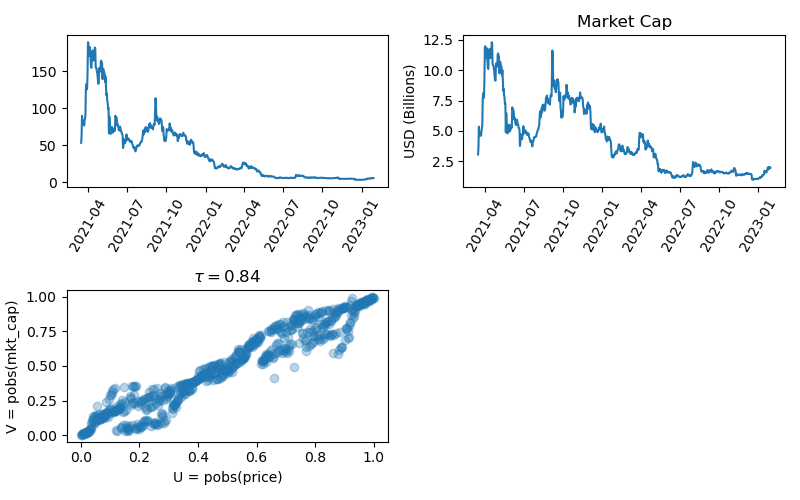

In [6]:
plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
plt.plot(usd_fil_exchange_df['date'], usd_fil_exchange_df['price'])
plt.xticks(rotation=60)

plt.subplot(2,2,2)
plt.plot(usd_fil_exchange_df['date'], usd_fil_exchange_df['market_caps']/1e9)
plt.xticks(rotation=60)
plt.ylabel('USD (Billions)')
plt.title('Market Cap')

X = np.vstack([usd_fil_exchange_df['price'].values, usd_fil_exchange_df['market_caps'].values]).T
ktau = kendalltau(X[:,0], X[:,1]).correlation
U = pobs(X)
plt.subplot(2,2,3)
plt.scatter(U[:,0], U[:,1], alpha=0.3)
plt.xlabel('U = pobs(price)')
plt.ylabel('V = pobs(mkt_cap)')
plt.title(r'$\tau=%0.02f$' % (ktau,))

plt.tight_layout()

In [7]:
rr = 0.6
rbp = 10
fpr = 0.6
sector_duration = 360
forecast_length=540
mechafil_df = sim.run_simple_sim(
    data_start_date,
    simulation_start_date,
    forecast_length,
    rr,
    rbp,
    fpr,
    sector_duration,
    qap_method = 'basic' # can be set to tunable or basic
                         # see: https://hackmd.io/O6HmAb--SgmxkjLWSpbN_A?view
)

/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [8]:
def add_generated_quantities(df:pd.DataFrame)->pd.DataFrame:
    # add ROI to trajectory df
    duration = 360
    GIB = 2 ** 30
    SECTOR_SIZE = 32 * GIB
    
    df['day_pledge_per_QAP'] = SECTOR_SIZE * (df['day_locked_pledge']-df['day_renewed_pledge'])/(df['day_onboarded_power_QAP'])
    df['day_rewards_per_sector'] = SECTOR_SIZE * df.day_network_reward / df.network_QAP
    df['1y_return_per_sector'] = df['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    df['1y_sector_roi'] = df['1y_return_per_sector'] / df['day_pledge_per_QAP']
    
    return df

In [9]:
mechafil_df = add_generated_quantities(mechafil_df)
merged_df = mechafil_df.merge(usd_fil_exchange_df, on='date', how='inner').dropna()

In [10]:
# prepare data for classification
EIB = 2**60

classifier_data = merged_df[['date', 'circ_supply', 'network_locked', 'network_QAP', '1y_sector_roi', 'market_caps', 'price']]
classifier_data['network_QAP'] = classifier_data['network_QAP'] / EIB
classifier_data['qap_grad'] = classifier_data['network_QAP'].diff()
classifier_data['market_cap_growth_rate'] = classifier_data['market_caps'].diff()/classifier_data['market_caps']

classifier_data = classifier_data.dropna()
classifier_data['locked_div_supply'] = classifier_data['network_locked'] / classifier_data['circ_supply']

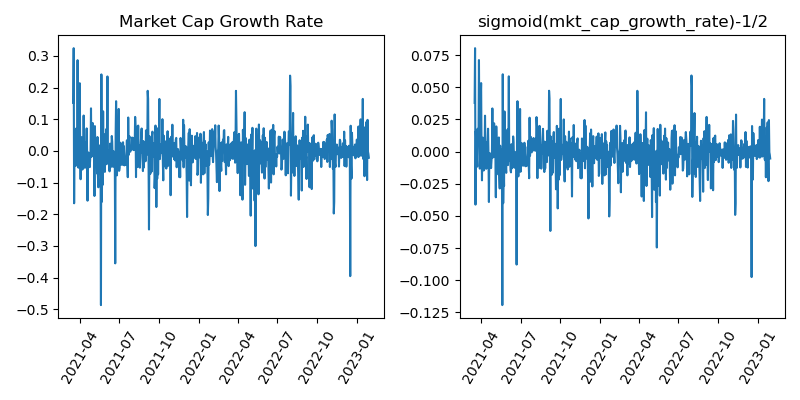

In [11]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(classifier_data['date'], classifier_data['market_cap_growth_rate'])
plt.xticks(rotation=60)
plt.title('Market Cap Growth Rate')

plt.subplot(1,2,2)
plt.plot(classifier_data['date'], expit(classifier_data['market_cap_growth_rate'])-0.5)
plt.xticks(rotation=60)
plt.title('sigmoid(mkt_cap_growth_rate)-1/2')

plt.tight_layout()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import SGDRegressor
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.neural_network import MLPRegressor

In [13]:
# Test a few classifiers
names = [
    'SVR', 
    'SGDRegression',
    'GPR',
    'MLP'
]
classifiers = [
    make_pipeline(StandardScaler(), svm.SVR()),
    make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3)),
    GaussianProcessRegressor(kernel=DotProduct()+WhiteKernel(), random_state=0),
    MLPRegressor(hidden_layer_sizes=[200,400,100], random_state=1, max_iter=500)
]

# TODO: cross-validation
X = classifier_data[['locked_div_supply', 'network_QAP', 'qap_grad', '1y_sector_roi', 'price']]
y = classifier_data['market_caps']

X_train , X_test , y_train, y_test = train_test_split(X, y, random_state=0)

for name, clf in zip(names, classifiers):
    clf.fit(X_train.values, y_train.values)
    score = clf.score(X_test.values, y_test.values)
    print(name, score)

SVR -0.07309300114208983
SGDRegression 0.9809133431578186
GPR 0.8817698432870811


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/cel/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


MLP 0.8918352020567659


/opt/anaconda3/envs/cel/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
market_cap_prediction_model = make_pipeline(StandardScaler(), SGDRegressor(max_iter=1000, tol=1e-3))
market_cap_prediction_model.fit(X.values, y.values)  # train on full data for usage

# model will be used in a time-series fashion, even though it isn't a time-series model b/c it
# uses inputs to predict market cap rather than the structure of the time-series.
# we use it in a time-series fashion because we map the market-cap growth rate to capital inflow

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [15]:
# Define the capital-inflow model
def capital_inflow_model(mkt_cap_growth_vec, current_circ_supply):
    """
    Inputs:
      - market cap growth rate vector - should be a history of n previous market-cap-growth values
      - current circulating supply
    Output:
      - The amount of FIL that will be inflowed into SPs as capital
    """
    # define the filter
    h = np.ones(len(mkt_cap_growth_vec))/len(mkt_cap_growth_vec)
    mkt_cap_growth_smoothed = np.sum(np.multiply(mkt_cap_growth_vec, h))
    
    # apply sigmoid function to convert to percentage of infil, 0 means no-new infil
    capital_inflow_pct = expit(mkt_cap_growth_smoothed)
    return capital_inflow_pct * current_circ_supply

In [16]:
# Demonstrate Usage of the model
example_df = copy.copy(merged_df)
example_df['market_cap_pred'] = 0
example_df['market_cap_growth'] = 0
example_df['fil_inflow'] = 0
example_df['network_QAP'] = example_df['network_QAP'] / EIB
example_df['qap_grad'] = example_df['network_QAP'].diff()
example_df['locked_div_supply'] = example_df['network_locked'] / example_df['circ_supply']

for ii, row in example_df.iterrows():
    if ii > 0: # lazy way to avoid nan
        X = row[['locked_div_supply', 'network_QAP', 'qap_grad', '1y_sector_roi', 'price']].values.reshape(1, -1)
        mkt_cap_pred = market_cap_prediction_model.predict(X)
        if ii > 1:
            prev_mkt_cap_pred = example_df.loc[ii-1, 'market_cap_pred']
            mkt_cap_growth = (mkt_cap_pred - prev_mkt_cap_pred)/prev_mkt_cap_pred
            fil_inflow = capital_inflow_model(mkt_cap_growth, example_df.loc[ii, 'circ_supply'])
            example_df.loc[ii, 'fil_inflow'] = fil_inflow
            example_df.loc[ii, 'market_cap_growth'] = mkt_cap_growth

        example_df.loc[ii, 'market_cap_pred'] = mkt_cap_pred

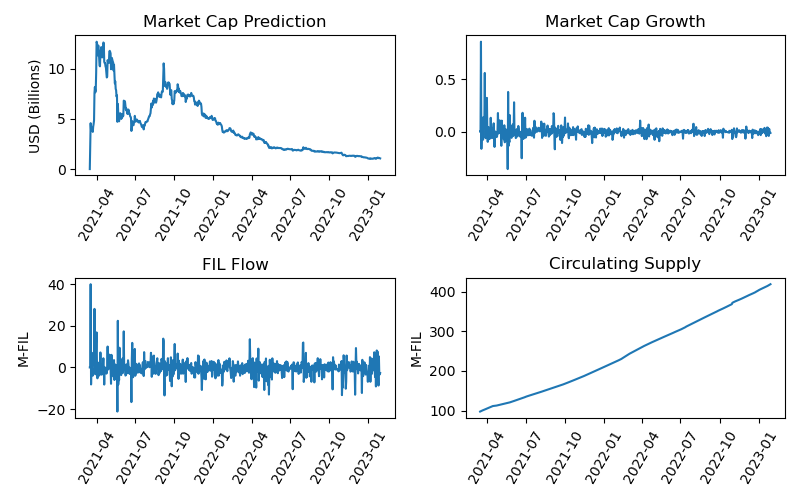

In [17]:
plt.figure(figsize=(8,5))

plt.subplot(2,2,1)
plt.plot(example_df['date'], example_df['market_cap_pred']/1e9)
plt.xticks(rotation=60)
plt.ylabel('USD (Billions)')
plt.title('Market Cap Prediction')

plt.subplot(2,2,2)
plt.plot(example_df['date'], example_df['market_cap_growth'])
plt.xticks(rotation=60)
# plt.ylabel('USD (Billions)')
plt.title('Market Cap Growth')

plt.subplot(2,2,3)
plt.plot(example_df['date'], example_df['fil_inflow']/1_000_000)
plt.xticks(rotation=60)
plt.ylabel('M-FIL')
plt.title('FIL Flow')

plt.subplot(2,2,4)
plt.plot(example_df['date'], example_df['circ_supply']/1_000_000)
plt.xticks(rotation=60)
plt.ylabel('M-FIL')
plt.title('Circulating Supply')


plt.tight_layout()